---
<u><h1>Bitcoin Price forecasting with LSTM and GRU</h1></u>
---
---

Bitcoin is the first decentralized digital currency. This means it is not governed by any central bank or some other authority. This cryptocurrency was created in the 2009 year but it becomes extremely popular in the 2017 year. Some experts call bitcoin "the currency of the future" or even lead it as an example of the social revolution. The bitcoin price has increased several times during the 2017 year. At the same time, it is very volatile. Many economic entities are interested in tools for forecasting the bitcoin prices. It is especially important for existing or potential investors and for government structures. The last needs to be ready for significant price movements to prepare consistent economic policy. So, the demand for Bitcoin price prediction mechanism is high.

This notebook demonstrates the prediction of the bitcoin price by the neural network model. We are using 2-layers long short term memory (LSTM) as well as Gated Recurrent Unit (GRU) architecture of the Recurrent neural network (RNN). You can read more about these types of NN here:

* https://deeplearning4j.org/lstm.html
* http://colah.github.io/posts/2015-08-Understanding-LSTMs/
* https://arxiv.org/pdf/1412.3555v1.pdf
* http://karpathy.github.io/2015/05/21/rnn-effectiveness/

The dataset we are using is available here: [Bitcoin Historical Data](https://www.kaggle.com/mczielinski/bitcoin-historical-data/data)

The first thing we do is **importing** all the necessary python libraries.

In [19]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
%matplotlib inline

Now we **load the dataset** in the memory and testing it for the presence of the null values:

In [20]:
data = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2018-01-08.csv')
data.isnull().values.any()

False

We can see that there are not null values. Now we want to preview the head of the dataset to know the structure of the data:

In [21]:
data.head(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
5,1325318220,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
6,1325318280,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
7,1325318340,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
8,1325318400,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
9,1325318460,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


We want to **transform the data** to get the average price grouped by the day and to see usual datetime format (not a timestamp as above).

In [22]:
data['date'] = pd.to_datetime(data['Timestamp'],unit='s').dt.date
group = data.groupby('date')
Daily_Price = group['Weighted_Price'].mean()

Daily_Price.head()

date
2011-12-31    4.472579
2012-01-01    4.680778
2012-01-02    5.000000
2012-01-03    5.145917
2012-01-04    5.195443
Name: Weighted_Price, dtype: float64

In [23]:
Daily_Price.tail()

date
2018-01-04    14816.625468
2018-01-05    15790.446145
2018-01-06    16665.268808
2018-01-07    16516.385962
2018-01-08    16122.406640
Name: Weighted_Price, dtype: float64

We need to **split our dataset** because we want to train and test the model only on some chunk of the data. So, in the next cell, we are counting the necessary parameters for splitting (number of days between some dates). We want to train our model on the data from January 1, 2016 until August 21, 2017 and to test the model on the data from August 21, 2017 until October 20, 2017.

In [33]:
# from datetime import date
# d0 = date(2016, 1, 1)
# d1 = date(2017, 10, 15)
# delta = d1 - d0
# days_look = delta.days + 1
# print(days_look)

# d0 = date(2017, 8, 21)
# d1 = date(2017, 10, 20)
# delta = d1 - d0
# days_from_train = delta.days + 1
# print(days_from_train)

# d0 = date(2017, 10, 15)
# d1 = date(2017, 10, 20)
# delta = d1 - d0
# days_from_end = delta.days + 1
# print(days_from_end)

654
61
6


Now we are splitting our data into the train and test set:

In [59]:
# df_train= Daily_Price[len(Daily_Price)-days_look-days_from_end:len(Daily_Price)-days_from_train]
# df_test= Daily_Price[len(Daily_Price)-days_from_train:]

# print(len(df_train), len(df_test)
# new_df= pd.DataFrame(list(Daily_Price), index = Daily_Price.index, columns = ["Close"])
# new_df.head()
# plt.plot(new_df)

df_train=Daily_Price[0:2000] 
df_test=Daily_Price[2000:]
# print(test.head())

In [60]:
df_train.head()

date
2011-12-31    4.472579
2012-01-01    4.680778
2012-01-02    5.000000
2012-01-03    5.145917
2012-01-04    5.195443
Name: Weighted_Price, dtype: float64

# Exploratory Data Analysis

We want to estimate some parameters of our data because this can be useful in the further model designing. 
The first important thing when forecasting time series is to **check if the data is stationary**. This means that our data is influenced by such factors as trend or seasonality. 

In the next cell, we concatenate train and test data to make analysis and transformations simultaneously.

In [61]:
working_data = [df_train, df_test]
working_data = pd.concat(working_data)

working_data = working_data.reset_index()
working_data['date'] = pd.to_datetime(working_data['date'])
working_data = working_data.set_index('date')

In the next couple of cells, we perform seasonal decomposition of the data to estimate its trend and seasonality. You can see actual price movements on the plot below ("observed") as well as the trend and seasonality in our data. 

In [62]:
s = sm.tsa.seasonal_decompose(working_data.Weighted_Price.values, freq=60)

In [63]:
trace1 = go.Scatter(x = np.arange(0, len(s.trend), 1),y = s.trend,mode = 'lines',name = 'Trend',
    line = dict(color = ('rgb(244, 146, 65)'), width = 4))
trace2 = go.Scatter(x = np.arange(0, len(s.seasonal), 1),y = s.seasonal,mode = 'lines',name = 'Seasonal',
    line = dict(color = ('rgb(66, 244, 155)'), width = 2))

trace3 = go.Scatter(x = np.arange(0, len(s.resid), 1),y = s.resid,mode = 'lines',name = 'Residual',
    line = dict(color = ('rgb(209, 244, 66)'), width = 2))

trace4 = go.Scatter(x = np.arange(0, len(s.observed), 1),y = s.observed,mode = 'lines',name = 'Observed',
    line = dict(color = ('rgb(66, 134, 244)'), width = 2))

data = [trace1, trace2, trace3, trace4]
layout = dict(title = 'Seasonal decomposition', xaxis = dict(title = 'Time'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='seasonal_decomposition')

The next thing we do is an examination of the **autocorrelation**. It is it is the similarity between observations as a function of the time lag between them. It is important for finding repeating patterns in the data. 

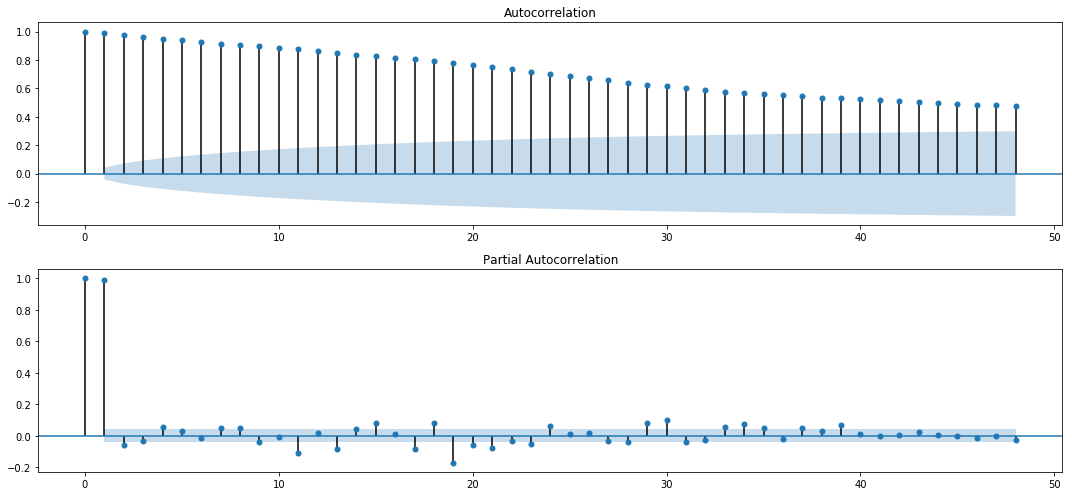

In [64]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(working_data.Weighted_Price.values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(working_data.Weighted_Price.values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

Now we need to recover our df_train and df_test datasets:

In [65]:
df_train = working_data[:-60]
df_test = working_data[-60:]

# Data preparation

We need to prepare our dataset according to the requirements of the model, as well as to split the dataset into train and test parts. 
In the next cell, we define a function which creates X inputs and Y labels for our model. In the sequential forecasting, we predict the future value based on some previous and current values. So, our Y label is the value from the next (future) point of time while the X inputs are one or several values from the past. The amount of this values we can set by tuning the parameter *look_back* in our function. If we set it to 1, this means that we predict current value *t* based on the previous value *(t-1)*.

In [66]:
def create_lookback(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

Now we perform **final data preparation**:
   1. Reshape the train and test set according to the requirements of the model.
   2. Scale the dataset by using the MinMaxScaler because LSTM models are scale sensitive.
   3. Apply our *create_lookback* function.

In [67]:
from sklearn.preprocessing import MinMaxScaler

training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
test_set = df_test.values
test_set = np.reshape(test_set, (len(test_set), 1))

#scale datasets
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
test_set = scaler.transform(test_set)

# create datasets which are suitable for time series forecasting
look_back = 1
X_train, Y_train = create_lookback(training_set, look_back)
X_test, Y_test = create_lookback(test_set, look_back)

 # reshape datasets so that they will be ok for the requirements of the LSTM model in Keras
X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

We have tried to train several different models and compare their results. You can found them in the table below.
These results were obtained using the following hardware: 4-core CPU, 16 GB RAM and by training each model ten times with different random states.
As we can see, the best result is obtained by using the 2-stacked LSTM. Nevertheless, this model is much slower then GRU or 1-layer LSTM. The Autoregressive integrated moving average model (ARIMA) shows the worst results both in performance and training time. We can also see, that the 1-layer LSTM model is not capable to recognize patterns in the data so we need more complex models. We are going to demonstrate 2-layers LSTM neural network in more detail. 

<table>
    <thead>
        <tr>
            <th>Model</th>
            <th>RMSE</th>
            <th>Training time, sec</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>ARIMA</td>
            <td>164</td>
            <td>166</td>
        </tr>
        <tr>
            <td>1-layer LSTM</td>
            <td>91.2 +- (2.2)</td>
            <td>21</td>
        </tr>
        <tr>
            <td>Bidirectional 1-layer LSTM</td>
            <td>51.6 +- (9.5)</td>
            <td>42</td>
        </tr>
        <tr>
            <td>Gated Recurrent Unit (GRU)</td>
            <td>32.6 +- (1.5)</td>
            <td>16</td>
        </tr>   
        <tr>
            <td>2-layers LSTM</td>
            <td>19.5 +- (4.2)</td>
            <td>57</td>
        </tr>        
    </tbody>
</table>


# Training 2-layers LSTM Neural Network

Eventually, we can build and train our model. We use Keras framework for deep learning. 
Our model consists of two stacked LSTM layers with 256 units each and the densely connected output layer with one neuron. We are using [Adam optimizer](https://arxiv.org/abs/1412.6980) and MSE as a loss. Also, we use an early stopping if the result doesn't improve during 20 training iterations (epochs).
We performed several experiments and found that the optimal number of epochs and butch_size is 100 and 16 respectively.
Also, it is important to set *shuffle=False* because we don't want to shuffle time series data.

In [68]:
# initialize sequential model, add 2 stacked LSTM layers and densely connected output neuron
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(256))
model.add(Dense(1))

# compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=100, batch_size=16, shuffle=False, 
                    validation_data=(X_test, Y_test), 
                    callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])

Train on 2137 samples, validate on 59 samples
Epoch 1/100
2137/2137 [==============================] - 5s 2ms/step - loss: 9.7324e-04 - val_loss: 0.2857
Epoch 2/100
2137/2137 [==============================] - 4s 2ms/step - loss: 0.0202 - val_loss: 0.3650
Epoch 3/100
2137/2137 [==============================] - 3s 2ms/step - loss: 0.0061 - val_loss: 0.0493
Epoch 4/100
2137/2137 [==============================] - 3s 2ms/step - loss: 1.3302e-04 - val_loss: 0.0259
Epoch 5/100
2137/2137 [==============================] - 3s 2ms/step - loss: 2.9849e-04 - val_loss: 0.0269
Epoch 6/100
2137/2137 [==============================] - 3s 2ms/step - loss: 8.5363e-05 - val_loss: 0.0174
Epoch 7/100
2137/2137 [==============================] - 3s 2ms/step - loss: 1.8244e-04 - val_loss: 0.0141
Epoch 8/100
2137/2137 [==============================] - 3s 2ms/step - loss: 1.0668e-04 - val_loss: 0.0114
Epoch 9/100
2137/2137 [==============================] - 3s 2ms/step - loss: 1.1613e-04 - val_loss: 0.0105

In [69]:
trace1 = go.Scatter(
    x = np.arange(0, len(history.history['loss']), 1),
    y = history.history['loss'],
    mode = 'lines',
    name = 'Train loss',
    line = dict(color=('rgb(66, 244, 155)'), width=2, dash='dash')
)
trace2 = go.Scatter(
    x = np.arange(0, len(history.history['val_loss']), 1),
    y = history.history['val_loss'],
    mode = 'lines',
    name = 'Test loss',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Train and Test Loss during training', 
              xaxis = dict(title = 'Epoch number'), yaxis = dict(title = 'Loss'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='training_process')

We trained our model. You can see that it has good performance even after several iterations. On the plot above, we compare the Train and Test loss on each iteration of the training process. We can see, that after some iterations train and test loss become very similar, which is a good sign (this means we are not overfitting the train set). 
Below, we use our model to **predict labels for the test set**. Then we inverse original scale of our data. You can see a comparison of true and predicted labels on the chart below. It looks like our model gives good results (lines are very similar)!

In [70]:
# add one additional data point to align shapes of the predictions and true labels
X_test = np.append(X_test, scaler.transform(working_data.iloc[-1][0]))
X_test = np.reshape(X_test, (len(X_test), 1, 1))

# get predictions and then make some transformations to be able to calculate RMSE properly in USD
prediction = model.predict(X_test)
prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
prediction2_inverse = np.array(prediction_inverse[:,0][1:])
Y_test2_inverse = np.array(Y_test_inverse[:,0])

In [71]:
trace1 = go.Scatter(
    x = np.arange(0, len(prediction2_inverse), 1),
    y = prediction2_inverse,
    mode = 'lines',
    name = 'Predicted price',
    hoverlabel= dict(namelength=-1),
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)
trace2 = go.Scatter(
    x = np.arange(0, len(Y_test2_inverse), 1),
    y = Y_test2_inverse,
    mode = 'lines',
    name = 'True price',
    line = dict(color=('rgb(66, 244, 155)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted',
             xaxis = dict(title = 'Day number'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating0')

Below we calculated the **root mean squared error** ([RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation)). The meaning of this indicator is what  is the average distance between predicted points on the test set and the actual (true) labels. In other words, it shows the extent of our error. The less this number, the better. We can see, that our model's RMSE is not very big (consider that the price in our data set is in thousands of USD, and we are mistaken only by tens of USD).

In [72]:
RMSE = sqrt(mean_squared_error(Y_test2_inverse, prediction2_inverse))
print('Test RMSE: %.3f' % RMSE)

Test RMSE: 688.899


Below we extract the convenient format of dates and plot the same chart as above, but with these dates on the X-axis. 

In [73]:
Test_Dates = Daily_Price[len(Daily_Price)-days_from_train:].index

trace1 = go.Scatter(x=Test_Dates, y=Y_test2_inverse, name= 'Actual Price', 
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Test_Dates, y=prediction2_inverse, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted, by dates',
             xaxis = dict(title = 'Date'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating1')

The results we obtained can be improved. For this, we will try the following thing. We get 10 different train and test datasets and train the model on each train test and then test it on the corresponding test dataset. After this, we calculate the RMSE for each pair of train/test dataset. Then we find an average RMSE on all these datasets and subtract this value from each prediction, obtained from our current model. This can improve the performance.

We want to demonstrate this approach on the GRU model just to show different models.

First what we do is to define three functions, which will be acting as subsequent elements in the pipeline. Basically, these functions are very similar to what we do when prepare data and train our previous 2-layers LSTM model.

In [74]:
# This function prepares random train/test split, 
# scales data with MinMaxScaler, create time series labels (Y)
def get_split(working_data, n_train, n_test, look_back = 1):
    # get a point from which we start to take train dataset and after it - test dataset
    start_point = randint(0, (len(working_data)-n_test-n_train))
    df_train = working_data[start_point:start_point+n_train]
    df_test = working_data[start_point+n_train:start_point+n_train+n_test]

    training_set = df_train.values
    training_set = np.reshape(training_set, (len(training_set), 1))
    test_set = df_test.values
    test_set = np.reshape(test_set, (len(test_set), 1))
    
    # scale datasets
    scaler_cv = MinMaxScaler()
    training_set = scaler_cv.fit_transform(training_set)
    test_set = scaler_cv.transform(test_set)

    # create datasets which are suitable for time series forecasting
    X_train, Y_train = create_lookback(training_set, look_back)
    X_test, Y_test = create_lookback(test_set, look_back)

    # reshape datasets so that they will be ok for the requirements of the models in Keras
    X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))
    
    return X_train, Y_train, X_test, Y_test, scaler_cv, start_point

# This function takes datasets from the previous function as input and train model using these datasets
def train_model(X_train, Y_train, X_test, Y_test):
    # initialize sequential model, add bidirectional LSTM layer and densely connected output neuron
    model = Sequential()
    model.add(GRU(256, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    
    # compile and fit the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs = 100, batch_size = 16, shuffle = False, 
                    validation_data=(X_test, Y_test), verbose=0,
                    callbacks = [EarlyStopping(monitor='val_loss',min_delta=5e-5,patience=20,verbose=0)])
    return model

# This function uses trained model and test dataset to calculate RMSE
def get_rmse(model, X_test, Y_test, scaler, start_point, working_data, n_train):
    # add one additional data point to align shapes of the predictions and true labels
    X_test = np.append(X_test, scaler.transform(working_data.iloc[start_point+n_train+len(X_test)][0]))
    X_test = np.reshape(X_test, (len(X_test), 1, 1))
    
    # get predictions and then make some transformations to be able to calculate RMSE properly in USD
    prediction = model.predict(X_test)
    prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
    Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
    prediction2_inverse = np.array(prediction_inverse[:,0][1:])
    Y_test2_inverse = np.array(Y_test_inverse[:,0])
    
    #calculate RMSE
    RMSE = sqrt(mean_squared_error(Y_test2_inverse, prediction2_inverse))
    return RMSE, prediction2_inverse

The function below uses all three previous functions to build workflow of calculations and return RMSE and predictions of the model.

In [75]:
def workflow(working_data, get_split, train_model, get_rmse,n_train = 250,n_test = 50,look_back = 1):
    X_train, Y_train, X_test, Y_test, scaler, start_point = get_split(working_data, n_train, n_test)
    model = train_model(X_train, Y_train, X_test, Y_test)
    RMSE, predictions = get_rmse(model, X_test, Y_test, scaler, start_point, working_data, n_train)
    return RMSE, predictions

Now we can run *workflow* function to calculate RMSE for single GRU model:

In [76]:
RMSE, predictions = workflow(working_data, get_split, train_model, get_rmse, n_train = 600,n_test = 60)
print('Test GRU model RMSE: %.3f' % RMSE)

Test GRU model RMSE: 1.063


In [77]:
# This function is used to repeat the workflow ten times and to calculate average RMSE
def cross_validate(working_data,get_split,train_model,get_rmse,workflow,n_train = 250,n_test = 50,look_back = 1):
    rmse_list = []
    for i in range(10):
        print('Iteration:', i+1)
        RMSE, _ = workflow(working_data, get_split, train_model, get_rmse, n_train, n_test, look_back)
        rmse_list.append(RMSE)
        print('Test RMSE: %.3f' % RMSE)
    mean_rmse = np.mean(rmse_list)
    return mean_rmse, rmse_list

Now we can run *cross_validate* function to trigger calculations:

In [78]:
mean_rmse, rmse_list = cross_validate(working_data, get_split, train_model, get_rmse, workflow)
print('Average RMSE: ', mean_rmse)
print('RMSE list:', rmse_list)

Iteration: 1
Test RMSE: 3.206
Iteration: 2
Test RMSE: 0.304
Iteration: 3
Test RMSE: 1.114
Iteration: 4
Test RMSE: 2.976
Iteration: 5
Test RMSE: 0.438
Iteration: 6
Test RMSE: 0.157
Iteration: 7
Test RMSE: 68.343
Iteration: 8
Test RMSE: 51.642
Iteration: 9
Test RMSE: 1.293
Iteration: 10
Test RMSE: 10.208
Average RMSE:  13.968026001050784
RMSE list: [3.2064280299420513, 0.3035251506276469, 1.1136890449625558, 2.9759643445955195, 0.43821361406905834, 0.15730120029426775, 68.34337879035928, 51.6416548821227, 1.2925338140150022, 10.207571139519764]


Next, we subtract the mean RMSE from each prediction our model produced. Then, we recalculate the RMSE for the model. 

In [79]:
predictions_new = predictions - mean_rmse

RMSE_new = sqrt(mean_squared_error(Y_test2_inverse, predictions_new))
print('Test GRU model RMSE_new: %.3f' % RMSE_new)

Test GRU model RMSE_new: 12762.198


We can see, that the RMSE has been reduced significantly. This means that our experiment was successful. On the plot below you can see the difference between predictions and true test labels.

In [80]:
trace1 = go.Scatter(x=Test_Dates, y=Y_test2_inverse, name= 'Actual Price', 
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Test_Dates, y=predictions_new, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted, by dates',
             xaxis = dict(title = 'Date'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating2')

Let's calculate symmetric mean absolute percentage error ([SMAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error)). It will show how good our predictions are in percentage. We define function *symmetric_mean_absolute_percentage_error*, which will perform all necessary calculations.

In [81]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred, epsilon = 1e-8): 
    return np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2 + epsilon)) * 100

SMAPE = symmetric_mean_absolute_percentage_error(Y_test2_inverse, predictions_new)

print('Test SMAPE (percentage): %.3f' % SMAPE)

Test SMAPE (percentage): 186.254


We can see that our SMAPE is less than 1%, which means that the error of our model is very small. 

In this notebook, we trained the 2-layers Long Short Term Memory Neural Network as well as Gated Recurrent Unit Neural Network using Bitcoin Historical Data. These models can be used to predict future price movements of bitcoin. The performance of the models is quite good. On average, both models considered here, makes an error measured only in tens of USD. 
 
 
 *Tags: Bitcoin, neural networks, machine learning, forecast, prediction, LSTM, GRU, RNN*